In [1]:
import numpy as np
import shutil
import seaborn as sns
import pandas as pd
import os

import neuro_morpho_toolbox as nmt

apo_path = '/home/penglab/Documents/SD_apo'
folder = os.path.exists(os.path.join(apo_path,'result'))
if not folder:  
    os.makedirs(os.path.join(apo_path,'result'))
for i_brain in os.listdir(apo_path):
    for i_folder in os.listdir(os.path.join(apo_path,i_brain)):
        if i_folder != 'result':
            continue
        if len(os.listdir(os.path.join(os.path.join(apo_path,i_brain),i_folder)))>0:
            for i_apo in os.listdir(os.path.join(os.path.join(apo_path,i_brain),i_folder)):
                oldname = os.path.join(os.path.join(os.path.join(apo_path,i_brain),i_folder),i_apo)
                newname = os.path.join(os.path.join(apo_path,'result'),i_apo)
                shutil.copyfile(oldname,newname)


/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.79
Loading CCF brain structure data...
Loading time: 0.00
Loading selected CCF Atlas and Contour data...
Loading time: 1.06


In [12]:
data_ALL = pd.DataFrame()
for i_apo in os.listdir(os.path.join(apo_path,'result')):
    path_apo_single = os.path.join(os.path.join(apo_path,'result'),i_apo)
    n_skip = 0
    with open(path_apo_single, "r") as f:
        for line in f.readlines():
            line = line.strip()
            if line.startswith("#"):
                n_skip += 1
            else:
                break
    names = ["##n","orderinfo","name","comment","z","x","y","pixmax","intensity","sdev","volsize","mass","","","",
             "color_r","color_g","color_b"]
    apo_read = pd.read_csv(path_apo_single, index_col=0, skiprows=n_skip, sep=",",
                      usecols=[0, 4, 5, 6],
                      names= ["##n","z","x","y"]
                          )
    apo_read.loc[:,'x'] = apo_read.loc[:,'x']-20
    apo_read.loc[:,'x'] = apo_read.loc[:,'x']*25
    apo_read.loc[:,'y'] = apo_read.loc[:,'y']*25
    apo_read.loc[:,'z'] = apo_read.loc[:,'z']*25
    apo_read.loc[:,'brain'] = i_apo.split("_")[0]
    data_ALL = data_ALL.append(apo_read)

In [13]:
data_ALL.loc[:, 'x'] = data_ALL.loc[:, 'x'].astype(int)
data_ALL.loc[:, 'y'] = data_ALL.loc[:, 'y'].astype(int)
data_ALL.loc[:, 'z'] = data_ALL.loc[:, 'z'].astype(int)
scale_data = data_ALL.copy()
scale_data["x"] = scale_data["x"] / nmt.annotation.space["x"]
scale_data["y"] = scale_data["y"] / nmt.annotation.space["y"]
scale_data["z"] = scale_data["z"] / nmt.annotation.space["z"]

for iter_idx in scale_data.index.tolist():
    structure_id = nmt.annotation.array[int(scale_data.loc[iter_idx,'x']), int(scale_data.loc[iter_idx,'y']), 
                                        int(scale_data.loc[iter_idx,'z'])]
    if structure_id in nmt.bs.dict_to_selected.keys():
        structure_id = nmt.bs.dict_to_selected[structure_id]
        cur_region = nmt.bs.level.loc[structure_id, "Abbreviation"]
    else:
        cur_region = "unknown"
    data_ALL.loc[iter_idx,'Region'] = cur_region

In [38]:

mouseDF = pd.read_excel('/home/penglab/FeaCal/dataSource/mouseDF.xlsx',index=0)
abbrlist = []
for i in mouseDF.loc[:,'idx']:
    if i in nmt.bs.level.index:
        abbr = nmt.bs.level.loc[i,'Abbreviation']
        abbrlist.append(abbr)
    else:
        print(i)
        abbrlist.append('unknown')
mouseDF.loc[:,'ABBR']=abbrlist
del mouseDF[1]
mouseDF.set_index(['idx'],inplace=True)

large_list = [ 'BS', 'CB','CNU', 'CTXsp', 'HPF','Isocortex', 'OLF']
mouseDF['FatherRe'] = mouseDF.loc[:,'ABBR']
        
for B_iter in large_list :
    temp=[]
    if nmt.bs.name_to_id(B_iter) in mouseDF.index:
        for child_iter in mouseDF.loc[nmt.bs.name_to_id(B_iter),'Child ID'].split():
            if int(child_iter) in mouseDF.index:
                mouseDF.loc[int(child_iter),'FatherRe'] = B_iter
            else:
                print(child_iter)
            #temp.append(nmt.bs.level.loc[int(child_iter),'Abbrevation'])
data_ALL['main7Region'] = data_ALL['Region']     
for iterR in data_ALL.index:
    if data_ALL.loc[iterR,'Region'] in mouseDF['ABBR'].tolist():
        data_ALL.loc[iterR,'main7Region'] = mouseDF[mouseDF['ABBR']==data_ALL.loc[iterR,'Region']].iloc[0,-1]
data_ALL.main7Region = data_ALL.main7Region.astype("category")
sorter = [ 'BS', 'CB','CNU', 'CTXsp', 'HPF','Isocortex', 'OLF', 'unknown']
data_ALL.main7Region.cat.set_categories(sorter, inplace=True)

In [117]:
len(nmt.bs.selected_regions)

316

In [116]:
len(mouseDF.ABBR.unique())

1327

In [118]:
len(data_ALL['brain'].unique())

6

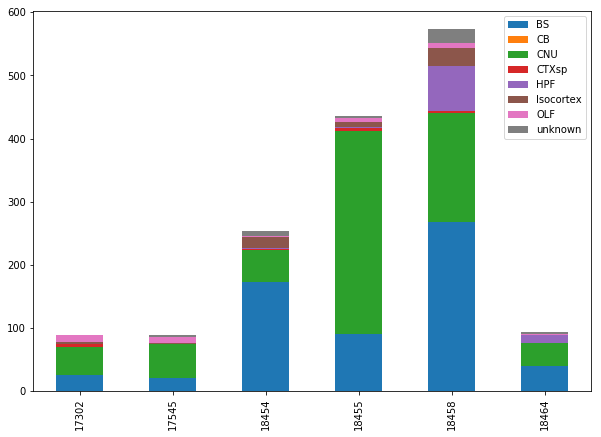

In [119]:
import matplotlib.pyplot as plt

selectedDF  = pd.DataFrame(columns = [ 'BS', 'CB','CNU', 'CTXsp', 'HPF','Isocortex', 'OLF', 'unknown'])
for iter_b in data_ALL['brain'].unique():   
    tempDF = data_ALL[data_ALL['brain'] == iter_b]
    for iter_idx in selectedDF.columns:
        if iter_idx in list(tempDF.main7Region.unique()):
            selectedDF.loc[iter_b,iter_idx] = list(tempDF['main7Region']).count(iter_idx)
        else:
            selectedDF.loc[iter_b,iter_idx] = 0
selectedDF.loc[:,'brain'] = selectedDF.index.tolist()
selectedDF.plot.bar(stacked = True, figsize=(10,7))

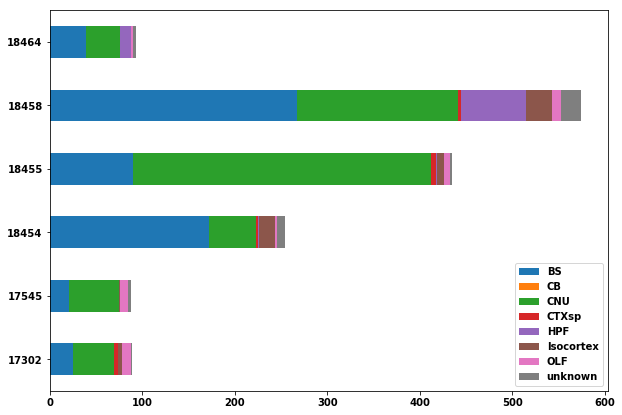

In [168]:

selectedDF.plot.barh(stacked = True, figsize=(10,7))

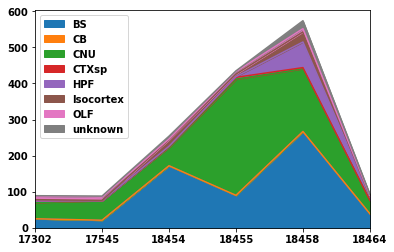

In [169]:

selectedDF.plot.area()


In [127]:
abbrL = []
for i in nmt.bs.selected_regions:
    abbrL.append(nmt.bs.id_to_name(i))

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
regionDF  = pd.DataFrame(columns = abbrL)
for iter_b in data_ALL['brain'].unique():   
    tempDF = data_ALL[data_ALL['brain'] == iter_b]
    for iter_idx in regionDF.columns:
        if iter_idx in list(tempDF.Region.unique()):
            regionDF.loc[iter_b,iter_idx] = list(tempDF['Region']).count(iter_idx)
        else:
            regionDF.loc[iter_b,iter_idx] = 0
for colname, sumR in zip(regionDF.columns,list(regionDF.sum())):
    if sumR < regionDF.sum().sort_values()[-15]:
        #print(sumR)
        regionDF.drop(colname, axis=1,inplace = True)
   

In [161]:
regionDF.sum().sort_values()[-15]

11.0

<Figure size 640x480 with 0 Axes>

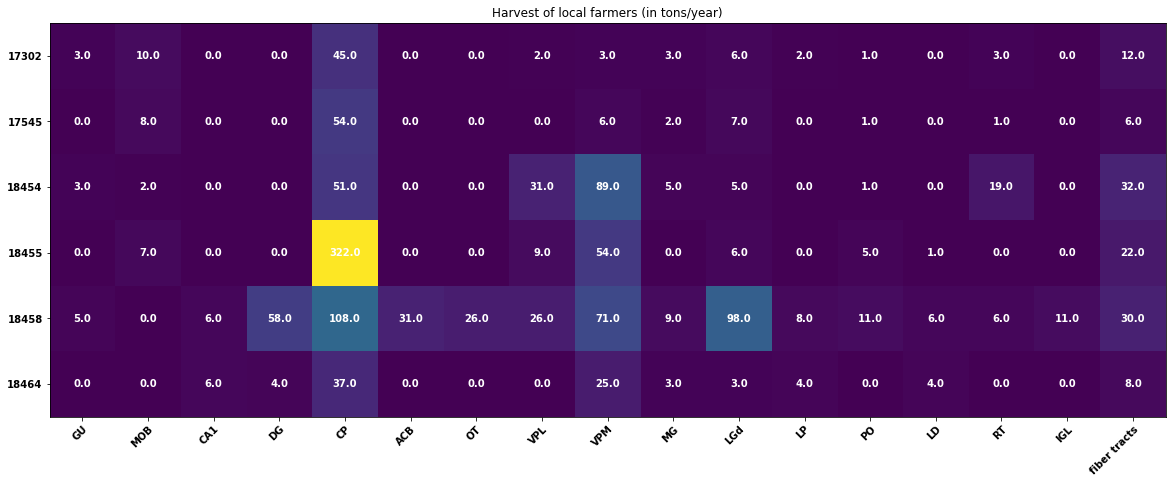

In [164]:
from matplotlib.pyplot import figure
import matplotlib
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
font = {'size'   : 10}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(20, 20))

im = ax.imshow(regionDF)

# We want to show all ticks...
ax.set_xticks(np.arange(len(regionDF.columns)))
ax.set_yticks(np.arange(len(regionDF.index)))
# ... and label them with the respective list entries
ax.set_xticklabels(regionDF.columns)
ax.set_yticklabels(regionDF.index)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(regionDF.index)):
    for j in range(len(regionDF.columns)):
        text = ax.text(j, i, regionDF.values[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
#fig.tight_layout()
plt.show()

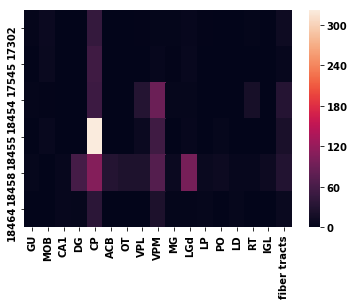

In [166]:
sns.heatmap(regionDF)

In [16]:

import numpy as np
import matplotlib.pyplot as plt


N = len(data_ALL['brain'].unique())
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()
Copy to clipboard
Download Python source code: bar_stacked.py
Download Jupyter notebook: bar_stacked.ipynb
© Copyright 2002 - 2012 John Hunter, Darren Dale, Eric Firing, Michael Droettboom and the Matplotlib development team; 2012 - 2018 The Matplotlib development team.
Last updated on Dec 17, 2019. Created using Sphinx 1.8.5. Doc version v3.1.1-75-g4a56626f5.

CP              617
VPM             248
LGd             125
fiber tracts    110
VPL              68
DG               62
unknown          39
ACB              31
RT               29
MOB              27
OT               26
MG               22
PO               19
LP               14
CA1              12
GU               11
IGL              11
LD               11
MOp              10
LGv               9
SSs               8
ZI                8
AON               8
CLA               8
RE                7
AId               7
IAD               6
SMT               6
MD                5
MOs               5
               ... 
CA3               5
PIR               4
CM                4
CEA               4
AM                4
SSp-ul            3
VM                3
ENTm              2
VISC              2
SUB               2
VPLpc             2
SI                2
AIv               2
BST               2
PoT               2
AIp               2
IC                1
RH                1
VAL               1


In [14]:
import plotly.express as px
#df = px.data.tips()
fig = px.bar(data_ALL, x="sex", y="total_bill", color='time')
fig.show()

,z,x,y,brain,Region
##n,,,,,
6109,6471,1480,5678,17302,MOB
6110,8581,4959,5142,17302,CP
6111,8552,4628,5033,17302,CP
6112,8646,4527,5004,17302,CLA
6113,8835,4695,4915,17302,CLA
6114,8844,4815,4862,17302,fiber tracts
6115,8625,4729,4543,17302,CP
6116,8554,4613,4685,17302,CP
6117,8951,4827,4822,17302,CLA
